<a href="https://colab.research.google.com/github/redgene/Air_Quality_TimeSeriesAnalysis/blob/main/Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Univariate + Multivariate Time Series Analysis + Forecasting

In [ ]:
import numpy as np 
import pandas as pd
import seaborn as sb
from sklearn.impute import SimpleImputer
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (15, 5)
import seaborn as sn
import statsmodels.api as sm
import math
from statsmodels.tsa.stattools import kpss, adfuller
from pmdarima import auto_arima
from statsmodels.tsa.vector_ar.var_model import VAR

# Understanding Data + Imputing for NO<sub>2</sub>

In [ ]:
df = pd.read_csv ('./AirQualityUCI.csv', sep = ';', na_values = -200)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         7765 non-null   object 
 3   PT08.S1(CO)    8991 non-null   float64
 4   NMHC(GT)       914 non-null    float64
 5   C6H6(GT)       9357 non-null   object 
 6   PT08.S2(NMHC)  8991 non-null   float64
 7   NOx(GT)        7718 non-null   float64
 8   PT08.S3(NOx)   8991 non-null   float64
 9   NO2(GT)        7715 non-null   float64
 10  PT08.S4(NO2)   8991 non-null   float64
 11  PT08.S5(O3)    8991 non-null   float64
 12  T              8991 non-null   object 
 13  RH             8991 non-null   object 
 14  AH             8991 non-null   object 
 15  Unnamed: 15    0 non-null      float64
 16  Unnamed: 16    0 non-null      float64
dtypes: float64(10), object(7)
memory usage: 1.2+ MB


In [ ]:
# pip list --outdated --format=freeze | grep -v '^\-e' | cut -d = -f 1  | xargs -n1 pip install -U

Completing Univariate Analysis First on NO2(GT) (already float)

Date and Time are objects, need to combine them first and then convert them into date-time objects

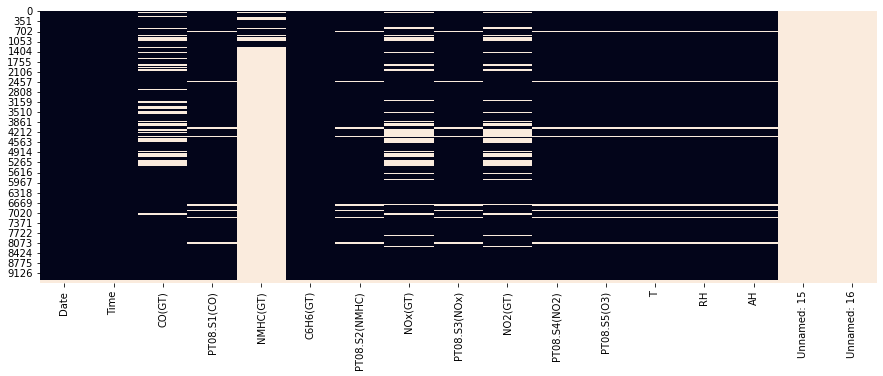

In [ ]:
sb.heatmap(df.isnull(), cbar = False);
# Conclusions
# - Remove the last 2 columns and NMHC (GT) [for multivariate analysis done later]
# - Imputing the data for NO2 since this is time series forecasting and ACF won't work properly if simply removed

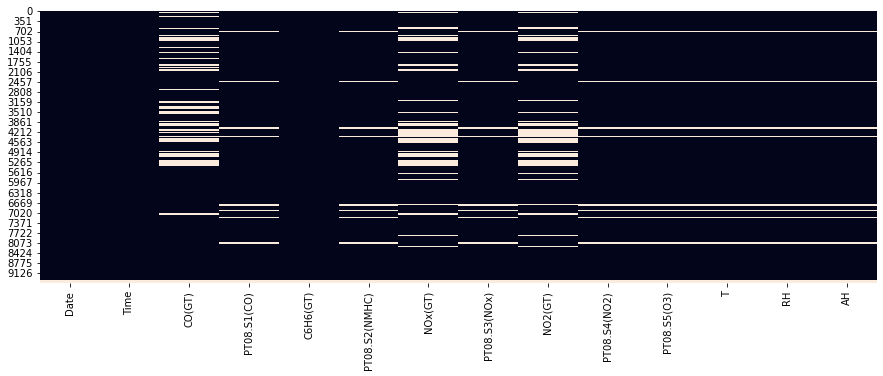

In [ ]:
df = df.drop (['Unnamed: 15', 'Unnamed: 16', 'NMHC(GT)'], axis = 1)
sb.heatmap(df.isnull(), cbar = False);

In [ ]:
df['TimeStamp'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format = '%d/%m/%Y %H.%M.%S')

timestamp = df['TimeStamp']
no2_level = df['NO2(GT)']

In [ ]:
df.head()

,Date,Time,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,TimeStamp
0,10/03/2004,18.00.00,"2,6",1360.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578",2004-03-10 18:00:00
1,10/03/2004,19.00.00,2,1292.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255",2004-03-10 19:00:00
2,10/03/2004,20.00.00,"2,2",1402.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502",2004-03-10 20:00:00
3,10/03/2004,21.00.00,"2,2",1376.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867",2004-03-10 21:00:00
4,10/03/2004,22.00.00,"1,6",1272.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888",2004-03-10 22:00:00


In [ ]:
df.describe()
# NO2 varies a lot min(2) to max(340)

,PT08.S1(CO),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3)
count,8991.000000,8991.000000,7718.000000,8991.000000,7715.000000,8991.000000,8991.000000
mean,1099.833166,939.153376,246.896735,835.493605,113.091251,1456.264598,1022.906128
std,217.080037,266.831429,212.979168,256.817320,48.370108,346.206794,398.484288
min,647.000000,383.000000,2.000000,322.000000,2.000000,551.000000,221.000000
25%,937.000000,734.500000,98.000000,658.000000,78.000000,1227.000000,731.500000
50%,1063.000000,909.000000,180.000000,806.000000,109.000000,1463.000000,963.000000
75%,1231.000000,1116.000000,326.000000,969.500000,142.000000,1674.000000,1273.500000
max,2040.000000,2214.000000,1479.000000,2683.000000,340.000000,2775.000000,2523.000000


In [ ]:
df = df[df['TimeStamp'].notna()]

In [ ]:
df['index_col'] = df.index
df = df.set_index('TimeStamp')

Analyzing for July 2004 to see a pattern

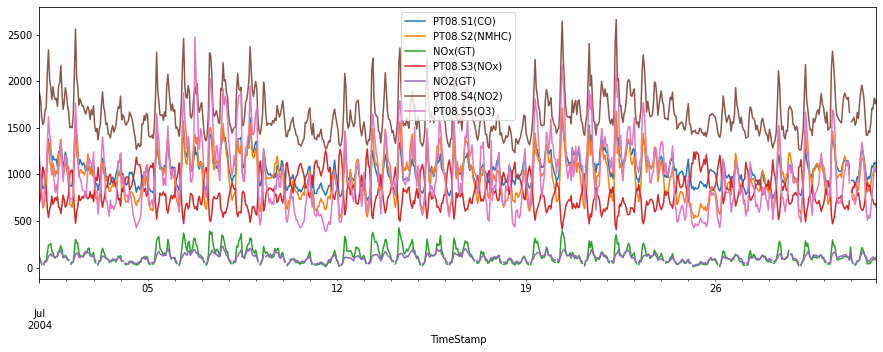

In [ ]:
levels_2004_July = df.drop(['index_col'], axis = 1).loc['2004-07']
levels_2004_July.plot();

Shows that concentrations of different gases are definitely correlated, some that don't make sense in the first go (such as NO2 and O3). 

Looking at only NO<sub>2</sub>

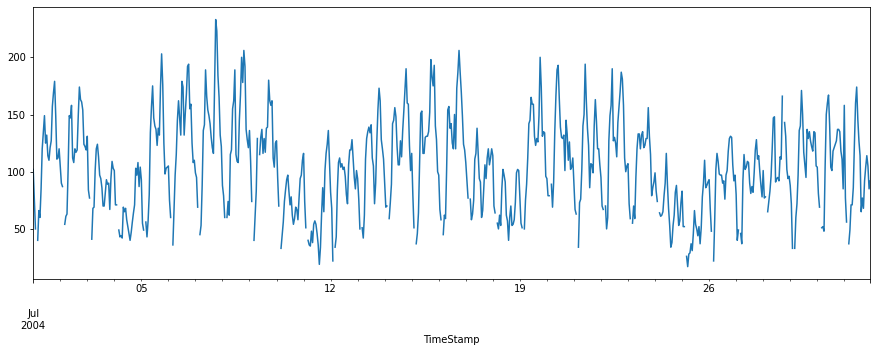

In [ ]:
no2_levels_2004_July = df.loc['2004-07']['NO2(GT)']
no2_levels_2004_July.plot(figsize = (15,5));

Within a day, the NO2 level peaks and then returns back to a value close to ~50

NO2 levels go down during the weekends (Example: 10-11th July, 17-18th July 2004)

Overall there is a weekly cyclic nature

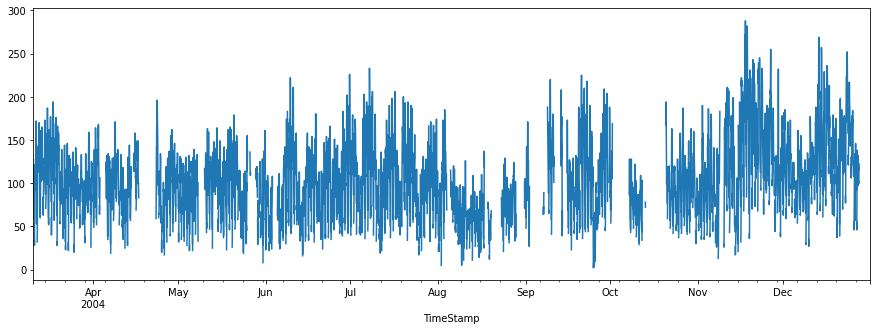

In [ ]:
no2_levels_2004 = df.loc['2004']['NO2(GT)']
no2_levels_2004.plot(figsize = (15,5));

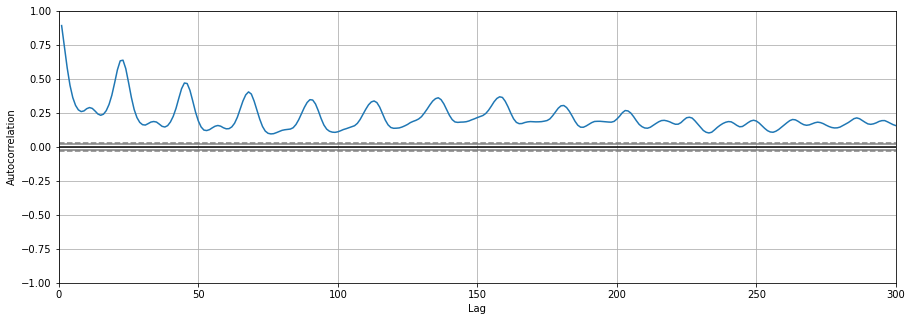

In [ ]:
# Correlation for NO2 data with different lag values (this was used for imputing)
df_no_na = df.dropna()
ax = pd.plotting.autocorrelation_plot(df_no_na['NO2(GT)'])
ax.set_xlim([0, 300]);

For NO<sub>2</sub> levels, there is a repeating trend at a lag of every 24, 48,.. hours -> Highly seasonal time series

But the data needs to be imputed. Possible strategies for imputing values for NO2:
- Remove those records where values are missing 
    [Can't do this since it will break the series]
    
- Impute with:
    - this day's last hour concentration (lag = 1)
    - the last day's concentration for the same hour (lag = 24)
    - last week same day, same hour concentration

    Last strategy for imputing looks good, from the July concentration graph above. But it is possible that the data is unavailable for that specific hour, so taking an average of multiple values to be on the safer side. So check the last week, or the week before that and so on; until a value is found. Since 24 hour lag seems to be the best, followed by 48 hour lag and so on..

In [ ]:
lst = list(range(1, 26, 4)) + [24*7] # list for lagplots
lst, len(lst) 

([1, 5, 9, 13, 17, 21, 25, 168], 8)

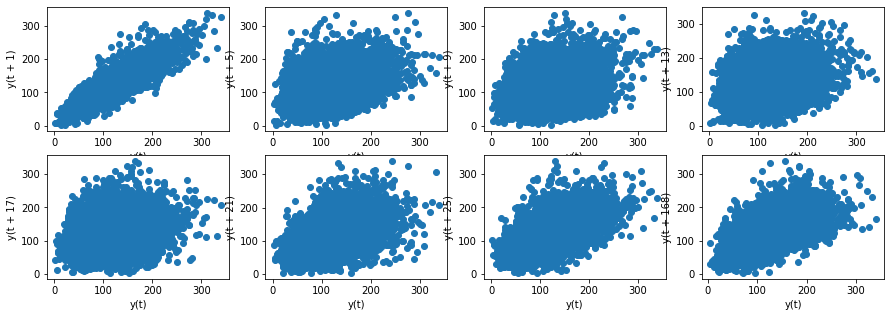

In [ ]:
# Checking for lag 1 through 24 hours and for 1 week

fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize = (15,5))
for n,lag in enumerate(lst):
    ax = plt.subplot(2, 4, n + 1)
    pd.plotting.lag_plot(df['NO2(GT)'], lag = lag)

In [ ]:
# sm.tsa.acf(df['NO2(GT)'].dropna().to_list(), nlags = 100, fft = False)

Observations:
- 24 hour lag doesn't seem to be good correlation
- 1 hour is good, but would fail multiple times because there are too many consecutive nans
- 1 week lag is not bad
- Trying a combination of these to fill in as many nans as possible

In [ ]:
df_imputed = df[['NO2(GT)']]

In [ ]:
k = df[['NO2(GT)']]
for i in range(30):
    k[f'NO2_shifted_{i}'] = df[['NO2(GT)']].shift(periods = i*24)

k = k.reset_index()
# df.index - pd.offsets.DateOffset(days = 7)

/Users/utkarshtripathi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
def helper (row, value):     
    index = row['index_col']
    val = np.nan
    
    for i in range(30):
        if math.isnan(k.loc[index][f'NO2_shifted_{i}']):
            continue
        else:
            val = k.loc[index][f'NO2_shifted_{i}']
            break

    # IF still nan, try taking the interpolation
    if math.isnan(value):
        avg = (k.loc[index-1]['NO2(GT)'] + k.loc[index+1]['NO2(GT)'])/2
        return avg
    else:
        return value

In [ ]:
# k['NO2_shifted_1'].head(25)

In [ ]:
# Try to fill with previous week same hour data as much as possible
df['imputed_NO2'] = df.apply (lambda row: helper(row, row['NO2(GT)']), axis = 1) 

# NA values was decreased, but not by the number I was expecting it to
# Better to take those months that have lower NaNs available [this is still hourly analysis]

# df['imputed_NO2'] = df['imputed_NO2'].fillna(method='ffill')
# df['imputed_NO2'] = df['imputed_NO2'].rolling(window = 24, min_periods = 1).mean()
df['imputed_NO2'].isna().sum()

1322

## Stationarity Check & quick ARIMA

In [ ]:
# no2_levels_2004_July = df.loc['2004']['imputed_NO2']
# no2_levels_2004_July.plot(figsize = (15,5));

In [ ]:
lst = []
def return_lowNA (r1, r2, string):
    for i in range(r1,r2):
        if df.loc[string + f'{i}']['imputed_NO2'].isna().sum() < 50:
            lst.append (string + f'{i}')

return_lowNA (4,  10, '2004-0')
return_lowNA (10, 13, '2004-')
return_lowNA (1,   5, '2005-0')

print(lst)

['2004-06', '2004-07', '2004-11', '2005-01', '2005-02', '2005-03', '2005-04']


In [ ]:
dfx = pd.concat([df.loc[month]['NO2(GT)'] for month in lst])

In [ ]:
dfx

TimeStamp
2004-06-01 00:00:00     45.0
2004-06-01 01:00:00     23.0
2004-06-01 02:00:00     26.0
2004-06-01 03:00:00      NaN
2004-06-01 04:00:00     24.0
                       ...  
2005-04-04 10:00:00    190.0
2005-04-04 11:00:00    179.0
2005-04-04 12:00:00    175.0
2005-04-04 13:00:00    156.0
2005-04-04 14:00:00    168.0
Name: NO2(GT), Length: 4431, dtype: float64

In [ ]:
dfx = dfx.reset_index()['NO2(GT)']
dfx = dfx.interpolate(limit_direction = "both")

In [ ]:
p1 = kpss(dfx, 'ct')[1] # ct passed if a distinctly visible trend avaialable
print(p1) # less than 0.05 implies non-stationarity

0.01


/Users/utkarshtripathi/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


<AxesSubplot:xlabel='TimeStamp'>

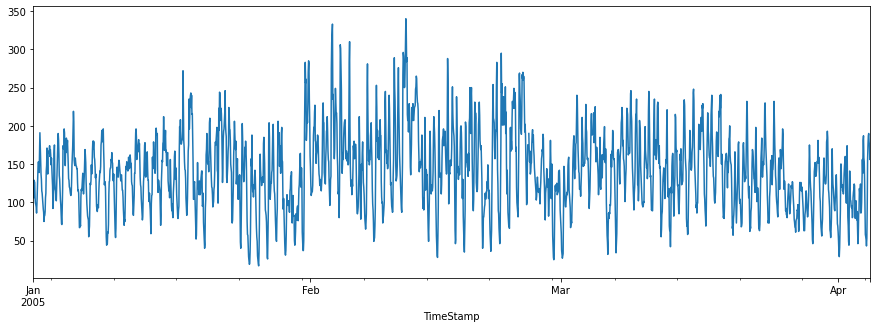

In [ ]:
df.loc['2005']['imputed_NO2'].plot()

In [ ]:
df_2005 = df.loc['2005']['imputed_NO2'].interpolate(limit_direction = "both") # for just those 3 NaNs remaining

In [ ]:
from statsmodels.tsa.stattools import kpss, acf
p1 = kpss(df_2005, 'c')[1] # ct passed if a distinctly visible trend avaialable
print(p1) # less than 0.05 implies non-stationarity

# p2 = adfuller(df_2005)
# print(p1, p2)

0.025261656555949398


In [ ]:
# roly-moly (rolling sorry PJ) stats shows it's not faily constant for daily data, but there is no trend as such
#  so will do ARIMA first then AR, ARMA, MA etc. ADFuller test shows it's stationary. It's a borderline case :(

# df_2005.rolling(window = 24).mean().plot()
# df_2005.rolling(window = 24).std().plot()

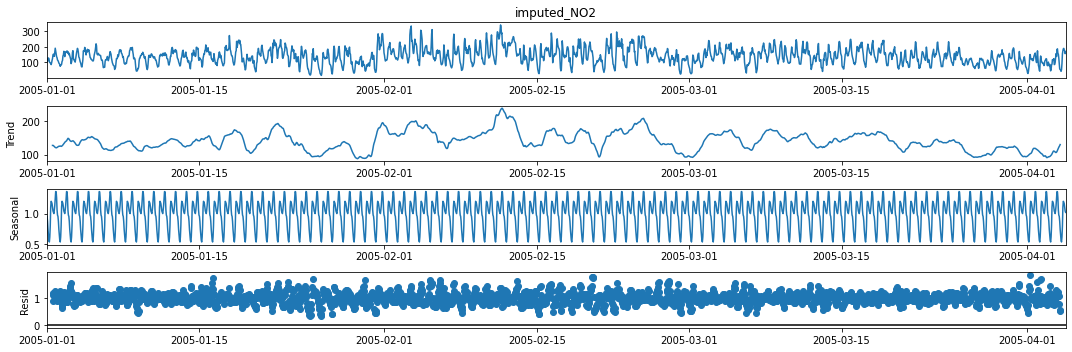

In [ ]:
decomposed = sm.tsa.seasonal_decompose(df_2005, model = 'additive')
df_2005_ = decomposed.observed - decomposed.trend
decomposed.plot();

In [ ]:
(df_2005_[12:-12]).isna().sum()
df_2005_ = df_2005_[12:-12] # for arima, we dont need to feed in the non-stationary data (isnt that great)

In [ ]:
train = df_2005_.loc['2005-01-01':'2005-04-01']
test  = df_2005_.loc['2005-04-02':]

In [ ]:
forecast = model.fit(train)
forecast = model.predict(n_periods = len(test))

In [ ]:
forecast_X = pd.DataFrame(forecast, index = test.index, columns = ['Next_vals'])

<AxesSubplot:xlabel='TimeStamp'>

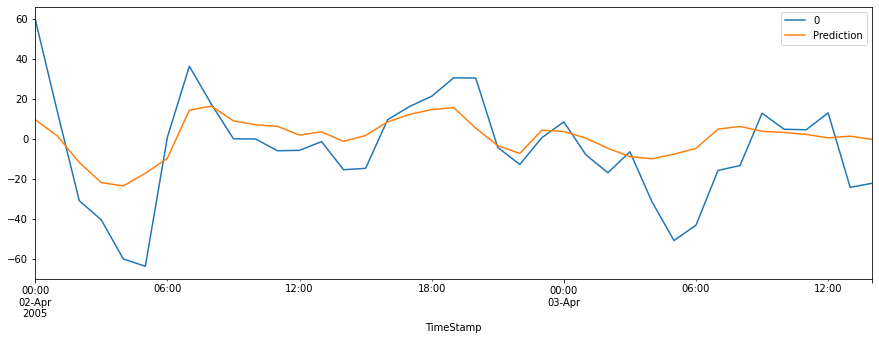

In [ ]:
pd.concat([test, forecast_X],axis=1).plot()

 :)

In [ ]:
# model = pm.auto_arima(df_2005_, m=12, seasonal = True, test = 'adf',error_action='ignore',\
#                       stepwise = False, trace = True)

## Modeling for Daily

34


<AxesSubplot:xlabel='TimeStamp'>

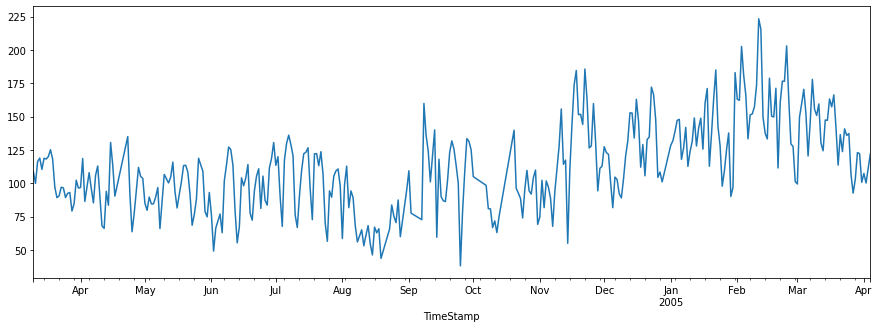

In [ ]:
df_ = df.resample('D').mean() # take a mean for daily data
print (df_['NO2(GT)'].isna().sum())
df_2 = df_['NO2(GT)'].interpolate(limit_direction = "both")
df_2.plot()

In [ ]:
p1 = kpss(df_2, 'ct')[1] # ct passed if a distinctly visible trend avaialable
print(p1) # < 0.05 implies non-stationarity

dftest = adfuller(df_2, autolag = 'AIC')
print (dftest[1]) # >0.05 implies non stationarity

0.01
0.17921936347881295


/Users/utkarshtripathi/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


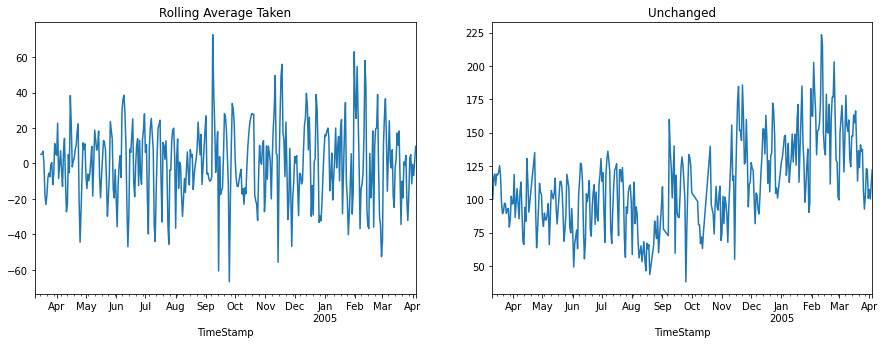

In [ ]:
# Removing Trend
rolling_mean = df_2.rolling(window = 7).mean()
df_2_noTrend = df_2 - rolling_mean

plt.subplot(121)
df_2_noTrend.plot(title="Rolling Average Taken");
plt.subplot(122)
df_2.plot(title="Unchanged");

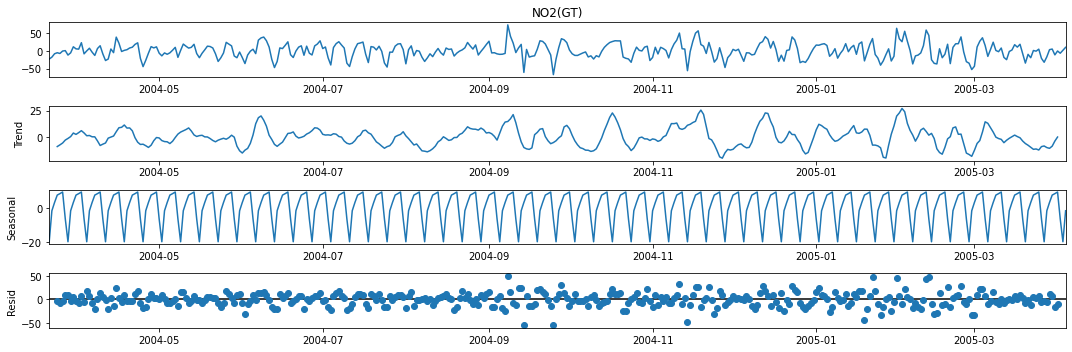

In [ ]:
df_2_noTrend = df_2_noTrend['2004-03-21':]
decomposed = sm.tsa.seasonal_decompose(df_2_noTrend, model = 'additive')
# df_2_ = decomposed.observed - decomposed.trend
decomposed.plot();

In [ ]:
dftest = adfuller(df_2_noTrend, autolag = 'AIC')
print (dftest[1]) # >0.05 implies non stationarity

1.091756720911131e-09


In [ ]:
# performing arima on this
model = pm.auto_arima(df_2_noTrend, m=7, seasonal = True, test = 'adf',error_action='ignore',\
                      stepwise = False, trace = True)

 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=3394.468, Time=0.01 sec
 ARIMA(0,0,0)(0,0,1)[7] intercept   : AIC=3391.496, Time=0.09 sec
 ARIMA(0,0,0)(0,0,2)[7] intercept   : AIC=3391.103, Time=0.19 sec
 ARIMA(0,0,0)(1,0,0)[7] intercept   : AIC=3390.441, Time=0.06 sec
 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(0,0,0)(1,0,2)[7] intercept   : AIC=inf, Time=0.72 sec
 ARIMA(0,0,0)(2,0,0)[7] intercept   : AIC=3386.092, Time=0.14 sec
 ARIMA(0,0,0)(2,0,1)[7] intercept   : AIC=inf, Time=0.65 sec
 ARIMA(0,0,0)(2,0,2)[7] intercept   : AIC=inf, Time=0.59 sec
 ARIMA(0,0,1)(0,0,0)[7] intercept   : AIC=3291.051, Time=0.11 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=3277.559, Time=0.25 sec
 ARIMA(0,0,1)(0,0,2)[7] intercept   : AIC=3275.704, Time=0.28 sec
 ARIMA(0,0,1)(1,0,0)[7] intercept   : AIC=3273.700, Time=0.13 sec
 ARIMA(0,0,1)(1,0,1)[7] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,0,1)(1,0,2)[7] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(0,0,1)(2,0,0)[7] intercept   : AI

In [ ]:
df_2_noTrend

TimeStamp
2004-03-21   -23.192547
2004-03-22   -17.813665
2004-03-23    -8.310559
2004-03-24    -5.440994
2004-03-25    -7.540373
                ...    
2005-03-31   -11.476190
2005-04-01    -0.571429
2005-04-02    -6.827381
2005-04-03     1.482143
2005-04-04     9.648810
Freq: D, Name: NO2(GT), Length: 380, dtype: float64

In [ ]:
train = df_2_noTrend.loc['2004-03-21':'2005-03-20']
test  = df_2_noTrend.loc['2005-03-21':]

In [ ]:
len(train), len(test)

(365, 15)

In [ ]:
forecast = model.fit(train)
forecast = model.predict(n_periods = len(test))

In [ ]:
forecast_X = pd.DataFrame(forecast, index = test.index, columns = ['Next_vals'])

<AxesSubplot:xlabel='TimeStamp'>

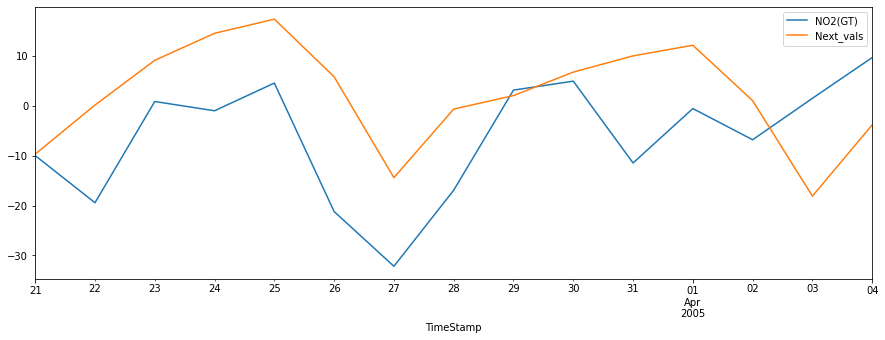

In [ ]:
pd.concat([test, forecast_X], axis=1).plot()

# Multivariate Analyzzizz

## Correlation Matrix

In [ ]:
df['NO2(GT)']

TimeStamp
2004-03-10 18:00:00    113.0
2004-03-10 19:00:00     92.0
2004-03-10 20:00:00    114.0
2004-03-10 21:00:00    122.0
2004-03-10 22:00:00    116.0
                       ...  
NaT                      NaN
NaT                      NaN
NaT                      NaN
NaT                      NaN
NaT                      NaN
Name: NO2(GT), Length: 9471, dtype: float64

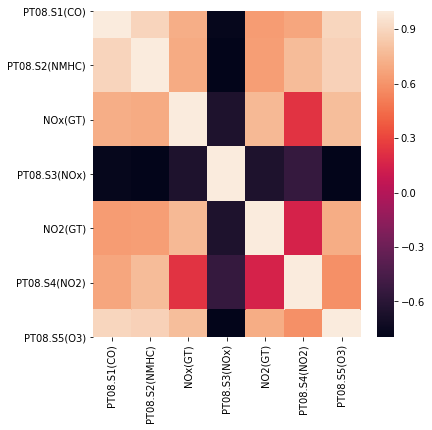

In [ ]:
corrMatrix = df.corr()
fig, ax = plt.subplots(figsize = (6,6))
sn.heatmap(corrMatrix, annot = False);

Observations: Since we are interested in predicting NO<sub>2</sub>, all except NOx, tungsten oxide look good predictors (not taking temperature, relative humidity etc for now)

In [ ]:
x_vars = ['PT08.S1(CO)', 'PT08.S2(NMHC)', 'NOx(GT)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)']

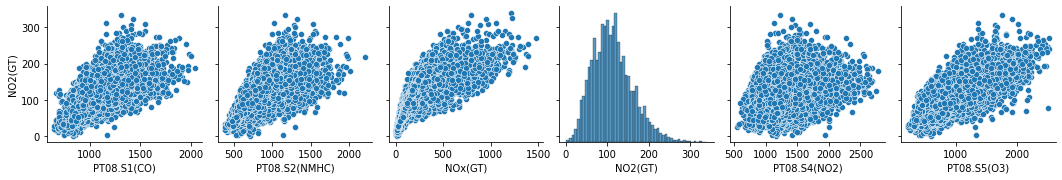

In [ ]:
sn.pairplot (df[x_vars], y_vars = ['NO2(GT)']);

In [ ]:
df_multi = df.resample('D').mean()

In [ ]:
df_multi

,PT08.S1(CO),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),index_col,imputed_NO2
TimeStamp,,,,,,,,,
2004-03-10,1316.500000,912.333333,132.000000,1167.333333,108.833333,1545.500000,1096.000000,2.5,108.833333
2004-03-11,1244.166667,851.958333,144.391304,1277.250000,99.869565,1522.833333,885.250000,17.5,97.666667
2004-03-12,1281.666667,1008.291667,173.727273,1101.875000,116.272727,1627.291667,1084.375000,41.5,114.625000
2004-03-13,1330.666667,992.833333,184.434783,993.208333,118.869565,1595.791667,1245.916667,65.5,117.354167
2004-03-14,1361.125000,943.916667,146.608696,1001.291667,110.391304,1602.375000,1234.208333,89.5,109.666667
...,...,...,...,...,...,...,...,...,...
2005-03-31,1008.125000,749.416667,185.083333,795.666667,100.708333,1176.541667,763.833333,9257.5,100.708333
2005-04-01,903.291667,663.000000,161.833333,946.875000,107.333333,943.250000,523.958333,9281.5,107.333333
2005-04-02,890.958333,616.291667,142.375000,991.750000,100.166667,864.333333,481.750000,9305.5,100.166667


In [ ]:
df_multi.isna().sum()

PT08.S1(CO)       8
PT08.S2(NMHC)     8
NOx(GT)          34
PT08.S3(NOx)      8
NO2(GT)          34
PT08.S4(NO2)      8
PT08.S5(O3)       8
index_col         0
imputed_NO2      34
dtype: int64

In [ ]:
df_multi = df_multi.interpolate(limit_direction = "both")

In [ ]:
for i, col in enumerate(x_vars):
    print(col, adfuller(df_multi[col])[1]) # <0.05 implies stationarity

PT08.S1(CO) 8.30828998149498e-17
PT08.S2(NMHC) 0.0015732324845519293
NOx(GT) 0.3568268381846265
NO2(GT) 0.17921936347881295
PT08.S4(NO2) 0.3657985143254272
PT08.S5(O3) 0.0003992170933603379


Need to make NOx, NO2, tungsten oxide data series stationary

In [ ]:
df_multi_stationary = df_multi.diff().dropna()

In [ ]:
for i, col in enumerate(x_vars):
    print(col, adfuller(df_multi_stationary[col])[1]) # <0.05 implies stationarity

PT08.S1(CO) 1.8237226910900484e-11
PT08.S2(NMHC) 3.370591060929868e-10
NOx(GT) 4.960123831236301e-11
NO2(GT) 3.6068503137062234e-09
PT08.S4(NO2) 3.3357168159110093e-09
PT08.S5(O3) 2.7415013882869992e-11


Transformed variables look good to go

In [ ]:
df_multi_stationary = df_multi.drop(['index_col', 'imputed_NO2'], axis = 1)

In [ ]:
df_multi_stationary

,PT08.S1(CO),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3)
TimeStamp,,,,,,,
2004-03-10,1316.500000,912.333333,132.000000,1167.333333,108.833333,1545.500000,1096.000000
2004-03-11,1244.166667,851.958333,144.391304,1277.250000,99.869565,1522.833333,885.250000
2004-03-12,1281.666667,1008.291667,173.727273,1101.875000,116.272727,1627.291667,1084.375000
2004-03-13,1330.666667,992.833333,184.434783,993.208333,118.869565,1595.791667,1245.916667
2004-03-14,1361.125000,943.916667,146.608696,1001.291667,110.391304,1602.375000,1234.208333
...,...,...,...,...,...,...,...
2005-03-31,1008.125000,749.416667,185.083333,795.666667,100.708333,1176.541667,763.833333
2005-04-01,903.291667,663.000000,161.833333,946.875000,107.333333,943.250000,523.958333
2005-04-02,890.958333,616.291667,142.375000,991.750000,100.166667,864.333333,481.750000


In [ ]:
# Source for this function: 
# https://stackoverflow.com/questions/58005681/is-it-possible-to-run-a-vector-autoregression-analysis-on-a-large-gdp-data-with

dataset = df_multi_stationary
maxlag=12
test = 'ssr-chi2test'
def grangers_causality_matrix(data, variables, test = 'ssr_chi2test', verbose=False):
    dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in dataset.columns:
        for r in dataset.index:
            test_result = grangercausalitytests(data[[r,c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            dataset.loc[r,c] = min_p_value

    dataset.columns = [var + '_x' for var in variables]
    dataset.index = [var + '_y' for var in variables]
    return dataset

grangers_causality_matrix(dataset, variables = dataset.columns)  

,PT08.S1(CO)_x,PT08.S2(NMHC)_x,NOx(GT)_x,PT08.S3(NOx)_x,NO2(GT)_x,PT08.S4(NO2)_x,PT08.S5(O3)_x
PT08.S1(CO)_y,1.0000,0.0000,0.0037,0.0036,0.0003,0.0001,0.0000
PT08.S2(NMHC)_y,0.0004,1.0000,0.1505,0.0009,0.0338,0.0072,0.0001
NOx(GT)_y,0.0000,0.0000,1.0000,0.0000,0.1326,0.0000,0.0000
PT08.S3(NOx)_y,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000
NO2(GT)_y,0.0000,0.0000,0.1306,0.0000,1.0000,0.0000,0.0000
PT08.S4(NO2)_y,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000
PT08.S5(O3)_y,0.0015,0.0019,0.0000,0.0026,0.0021,0.0005,1.0000


Looking at the NO2(GT)-y row: PT08.S1(CO), PT08.S2(NMHC), PT08.S3(NOx), PT08.S4(NO2), PT08.S5(O3) can be taken as features.

In [ ]:
# df_multi_ = df_multi_stationary[['PT08.S1(CO)','PT08.S2(NMHC)','PT08.S5(O3)', 'NO2(GT)', 'PT08.S3(NOx)']]
df_multi_ = df_multi[['PT08.S1(CO)','PT08.S2(NMHC)','PT08.S5(O3)', 'NO2(GT)', 'PT08.S3(NOx)']]
# taking non-stationary data is easier (there is a nice parameter that enforces stionarity)
# otherwise retransform the transformed data into original for comparison

df_train  = df_multi_[:-10]
df_test   = df_multi_[-10:]

model = VAR(df_train)
model.select_order(10).summary()

,AIC,BIC,FPE,HQIC
0,43.70,43.76,9.554e+18,43.72
1,39.59,39.91*,1.560e+17,39.71*
2,39.55,40.13,1.507e+17,39.78
3,39.47,40.31,1.382e+17,39.80
4,39.51,40.62,1.450e+17,39.95
5,39.55,40.92,1.501e+17,40.09
6,39.54,41.18,1.492e+17,40.19
7,39.47,41.37,1.388e+17,40.22
8,39.36*,41.53,1.252e+17*,40.22
9,39.39,41.82,1.288e+17,40.35


Should try 1 and 8 lags

In [ ]:
var_model = sm.tsa.VARMAX (df_train, enforce_stationarity = True)
modelFit = var_model.fit (disp=False)
trainingSize = len(df_train)
model_predictions = modelFit.get_prediction (start = trainingSize, end = trainingSize + 5).predicted_mean

/Users/utkarshtripathi/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [ ]:
model_predictions['NO2(GT)']

2005-03-26    121.700914
2005-03-27    114.828126
Freq: D, Name: NO2(GT), dtype: float64

In [ ]:
df_multi['2005-03-26':'2005-03-27']['NO2(GT)']

TimeStamp
2005-03-26    106.541667
2005-03-27     92.583333
Freq: D, Name: NO2(GT), dtype: float64

In [ ]:
# list (df_multi['2005-03-26':'2005-04-15'].index)
# pd.DatetimeIndex ['2005-03-26':'2005-04-15']

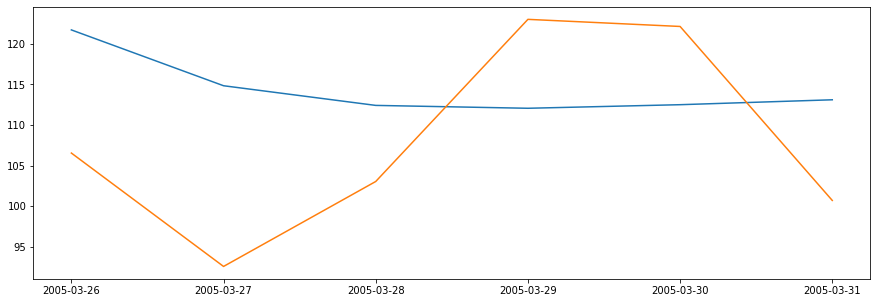

In [ ]:
x = list (df_multi['2005-03-26':'2005-03-31'].index)
plt.plot (x, model_predictions['NO2(GT)'], x, df_multi['2005-03-26':'2005-03-31']['NO2(GT)'])

### Approach 2

In [ ]:
lag = 8 # for creating the equation
ret = model.fit(lag)
# ret.summary() # creates equations for all 

In [ ]:
input_data = df_train.values[-lag:]

pred = ret.forecast(y = input_data, steps = 10)
pred = (pd.DataFrame(pred, index = df_test.index))
pred

,0,1,2,3,4
TimeStamp,,,,,
2005-03-26,1193.144342,879.338299,1033.029544,115.328066,699.952999
2005-03-27,1131.017946,830.711632,945.650321,105.454243,758.647108
2005-03-28,1167.425444,914.607167,1048.220435,119.074566,721.081722
2005-03-29,1181.721465,938.522693,1099.964894,121.406158,730.186917
2005-03-30,1163.541391,934.532336,1093.682526,121.659631,726.371623
2005-03-31,1153.358861,902.903036,1053.729150,118.619798,745.214044
2005-04-01,1154.155471,914.310214,1065.862065,121.117370,750.659696
2005-04-02,1118.325620,855.300204,980.995680,113.607098,809.717148
2005-04-03,1112.063990,848.998221,961.360294,111.087358,812.077818


In [ ]:
df_test

,PT08.S1(CO),PT08.S2(NMHC),PT08.S5(O3),NO2(GT),PT08.S3(NOx)
TimeStamp,,,,,
2005-03-26,1216.541667,910.541667,1185.875000,106.541667,590.041667
2005-03-27,1106.333333,723.166667,884.750000,92.583333,726.041667
2005-03-28,1079.666667,745.166667,829.583333,103.041667,748.125000
2005-03-29,1163.333333,943.416667,1133.333333,123.000000,632.083333
2005-03-30,1106.000000,908.791667,1067.416667,122.125000,665.833333
2005-03-31,1008.125000,749.416667,763.833333,100.708333,795.666667
2005-04-01,903.291667,663.000000,523.958333,107.333333,946.875000
2005-04-02,890.958333,616.291667,481.750000,100.166667,991.750000
2005-04-03,981.375000,714.708333,717.083333,111.125000,856.166667


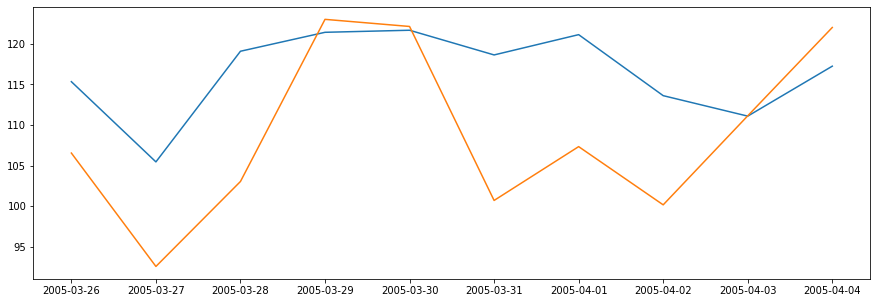

In [ ]:
x = list (df_test['2005-03-26':'2005-04-04'].index)
plt.plot (x, pred[3], x, df_test['2005-03-26':'2005-04-04']['NO2(GT)'])